In [1]:
!pip install mltu tqdm

In [2]:
import os
import cv2
import numpy as np
import typing
import tensorflow as tf
from datetime import datetime
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tqdm import tqdm
from mltu.preprocessors import ImageReader
from mltu.transformers import ImageResizer, LabelIndexer, LabelPadding, ImageShowCV2
from mltu.augmentors import RandomBrightness, RandomRotate, RandomErodeDilate, RandomSharpen
from mltu.annotations.images import CVImage
from mltu.tensorflow.dataProvider import DataProvider
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.callbacks import Model2onnx, TrainLogger
from mltu.tensorflow.metrics import CERMetric, WERMetric
from mltu.utils.text_utils import ctc_decoder, get_cer, get_wer
from mltu.configs import BaseModelConfigs


In [3]:
import os
from tqdm import tqdm

# Define dataset paths
dataset_path = "/kaggle/input/iamsentences"
sentences_txt_path = os.path.join(dataset_path, "metadata", "sentences.txt")
sentences_folder_path = os.path.join(dataset_path, "dataset")

# Parse dataset
dataset, vocab, max_len = [], set(), 0
flag = 0
with open(sentences_txt_path, "r") as f:
    for line in tqdm(f.readlines()):
        if flag > 1000:
            break
        flag += 1
        # Skip lines that are comments or contain the word "err"
        if line.startswith("#") or "err" in line.split():
            continue
        
        # Split the line to extract the necessary parts
        line_split = line.split()
        
        # Ensure the line is valid (checking if the filename and label are present)
        if len(line_split) < 2:
            continue
        
        # The first part of the line is the image filename
        image_filename = line_split[0] + ".png"  # Ensure the file has a .png extension
        
        # The label is in the last part of the line
        label = line_split[-1].replace("|", " ").rstrip()
        
        # Construct the full path to the image in the 'dataset' folder
        image_path = os.path.join(sentences_folder_path, image_filename)
        
        
        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Image not found at {image_path}")  # Debugging print
            continue
        
        # Add the image path and label to the dataset
        dataset.append([image_path, label])
        
        # Update vocabulary and maximum label length
        vocab.update(label)
        max_len = max(max_len, len(label))

# Check the dataset after parsing
print(f"Dataset contains {len(dataset)} samples.")
print(f"Vocabulary size: {len(vocab)}")
print(f"Maximum label length: {max_len}")


  6%|▌         | 1001/16777 [00:01<00:24, 637.34it/s]

Dataset contains 841 samples.
Vocabulary size: 73
Maximum label length: 69


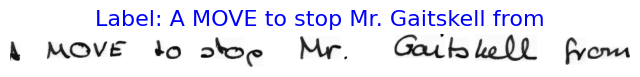

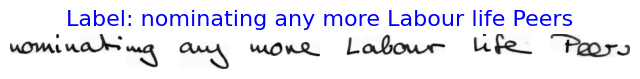

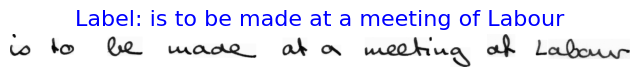

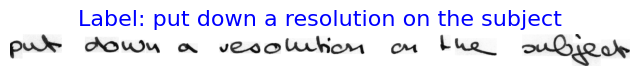

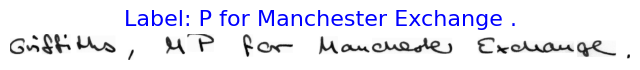

In [4]:
import matplotlib.pyplot as plt
import cv2

# Function to display images and their labels one by one
def display_images_one_by_one(dataset, num_images=15):
    for i in range(min(num_images, len(dataset))):
        image_path, label = dataset[i]
        
        # Read the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        
        # Display the image and its label
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}", fontsize=16, color="blue")
        plt.axis("off")
        plt.show()

# Display the first 5 images and their labels one by one
display_images_one_by_one(dataset, num_images=5)

Processing dataset: 100%|██████████| 841/841 [00:01<00:00, 444.28it/s]


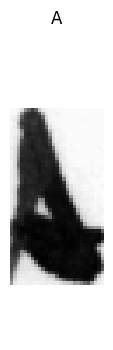

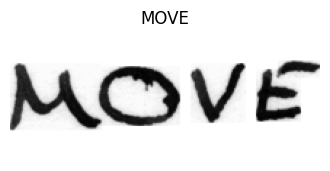

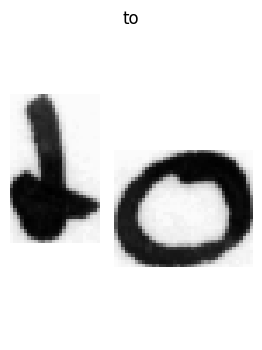

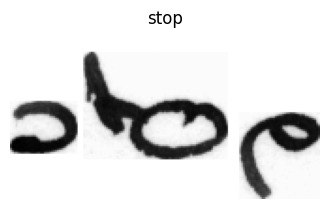

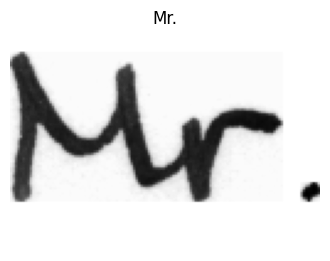

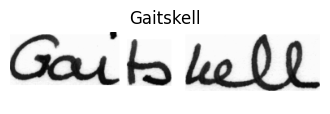

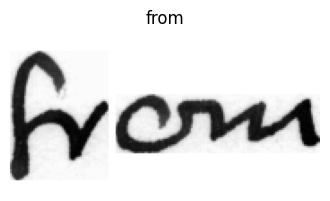

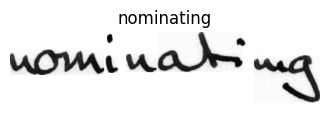

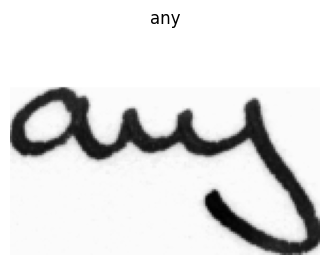

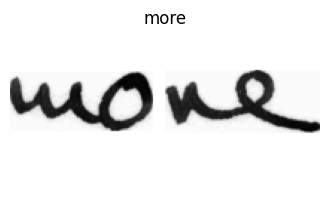

In [10]:
def process_and_split_dataset(dataset, threshold=128, min_white_columns=20):
    """
    Processes and splits the images in the dataset based on blank spaces and assigns corresponding labels.

    Args:
        dataset (list): List of [image_path, label] pairs.
        threshold (int): Threshold value for binarization.
        min_white_columns (int): Minimum length of continuous white columns to consider as a split point.

    Returns:
        List of tuples: Each tuple contains the split image segment and its corresponding word label.
    """
    processed_data = []

    for image_path, label in tqdm(dataset, desc="Processing dataset"):
        # Load the grayscale image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Convert the image to binary format
        binary_image = (image > threshold).astype(np.uint8)

        # Identify columns that are entirely white
        white_columns = np.all(binary_image == 1, axis=0)

        # Find continuous regions of white columns
        white_column_indices = np.where(white_columns)[0]
        splits = []
        current_start = None

        # Group continuous white columns longer than `min_white_columns`
        for i in range(len(white_column_indices)):
            if current_start is None:
                current_start = white_column_indices[i]

            if i == len(white_column_indices) - 1 or white_column_indices[i + 1] != white_column_indices[i] + 1:
                length = white_column_indices[i] - current_start + 1
                if length > min_white_columns:
                    splits.append((current_start, white_column_indices[i]))
                current_start = None

        # Split the image based on the identified regions
        split_images = []
        last_end = 0

        for start, end in splits:
            if start > last_end:
                split_images.append(image[:, last_end:start])
            last_end = end + 1

        # Save the final segment after the last white region
        if last_end < binary_image.shape[1]:
            split_images.append(image[:, last_end:])

        # Split the label into words
        split_labels = label.split(" ")

        # Ensure the number of splits matches the number of words in the label
        if len(split_images) == len(split_labels):
            processed_data.extend(zip(split_images, split_labels))
        else:
            #print(f"Warning: Mismatch in splits and labels for image {image_path}")
            pass

    return processed_data

def display_processed_data(processed_data):
    """
    Displays the processed image segments with their corresponding labels.

    Args:
        processed_data (list): List of tuples, where each tuple contains an image segment and a label.
    """
    for idx, (segment, segment_label) in enumerate(processed_data):
        plt.figure(figsize=(4, 4))
        plt.imshow(segment, cmap="gray")
        plt.title(segment_label)
        plt.axis("off")
        plt.show()


# Process the dataset
processed_dataset = process_and_split_dataset(dataset)

# Display some of the processed data
display_processed_data(processed_dataset[:10])  # Display first 10 samples


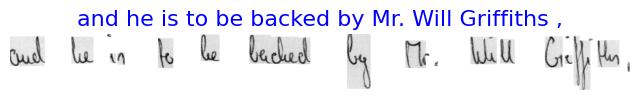

In [18]:
image_0_path, label_0 = dataset[10]
image = cv2.imread(image_0_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    print(f"Failed to load image: {image_path}")
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap="gray")
plt.title(label_0, fontsize=16, color="blue")
plt.axis("off")
plt.show()

['and', 'he', 'is', 'to', 'be', 'backed', 'by', 'Mr.', 'Will', 'Griffiths', ',']


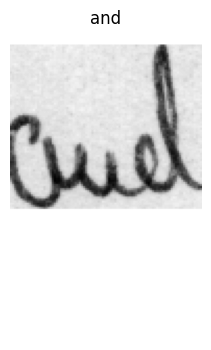

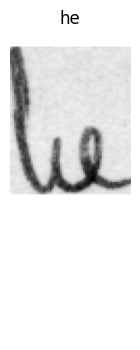

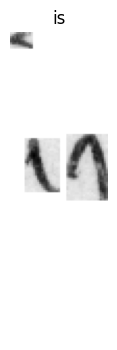

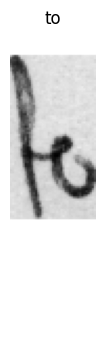

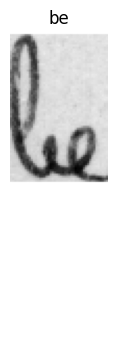

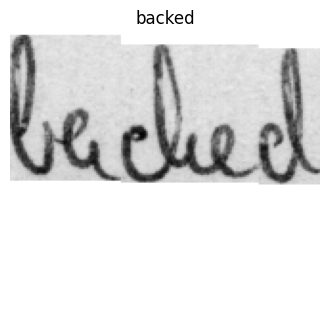

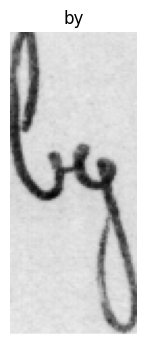

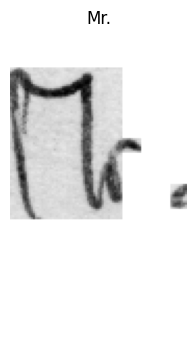

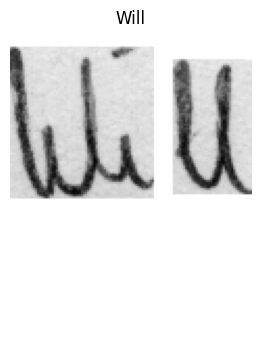

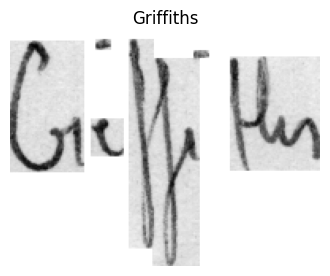

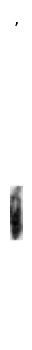

In [20]:
if image is None:
    print("Failed to load image. Please check the file path.")
else:
    # Convert the image to a binary format (0 and 1)
    threshold = 128  # Threshold value for binarization
    binary_image = (image > threshold).astype(np.uint8)

    # Check for columns that are all white
    white_columns = np.all(binary_image == 1, axis=0)

    # Find continuous regions of white columns
    white_column_indices = np.where(white_columns)[0]
    splits = []
    current_start = None

    # Group continuous white columns longer than 20
    for i in range(len(white_column_indices)):
        if current_start is None:
            current_start = white_column_indices[i]

        if i == len(white_column_indices) - 1 or white_column_indices[i + 1] != white_column_indices[i] + 1:
            length = white_column_indices[i] - current_start + 1
            if length > 20:  # Check if the region has more than 20 continuous white columns
                splits.append((current_start, white_column_indices[i]))
            current_start = None

    # Split the image based on the identified regions
    split_images = []
    last_end = 0

    for start, end in splits:
        # Save the segment before the current white region
        if start > last_end:
            split_images.append(image[:, last_end:start])
        last_end = end + 1  # Update the end of the last processed region

    # Save the final segment after the last white region
    if last_end < binary_image.shape[1]:
        split_images.append(image[:, last_end:])

    split_label = label_0.split(" ")
    print(split_label)

    # Assuming `split_images` is a list of image segments
    for idx, segment in enumerate(split_images):
        plt.figure(figsize=(4, 4))
        plt.imshow(segment, cmap="gray")
        plt.title(split_label[idx])
        plt.axis("off")
        plt.show()

In [ ]:
from tensorflow.keras import layers, Model

def residual_block(x, filters, activation="relu", skip_conv=True, strides=1, dropout=0.2):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    if skip_conv:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
    x = layers.add([shortcut, x])
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)
    return x

def multi_head_attention(x, num_heads=8, key_dim=64):
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attention = layers.LayerNormalization()(attention)
    return attention

def train_model(input_dim, output_dim, activation="relu", dropout=0.3):
    inputs = layers.Input(shape=input_dim, name="input")
    x = layers.Lambda(lambda x: x / 255)(inputs)

    # Deep Residual Blocks
    x = residual_block(x, 32, activation, skip_conv=True, strides=1, dropout=dropout)
    x = residual_block(x, 64, activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 128, activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 256, activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 512, activation, skip_conv=True, strides=2, dropout=dropout)
    x = residual_block(x, 512, activation, skip_conv=False, strides=1, dropout=dropout)  # Deeper block

    # Attention Mechanism with Multi-head Attention
    squeezed = layers.Reshape((x.shape[-3] * x.shape[-2], x.shape[-1]))(x)
    blstm = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(squeezed)
    mha = multi_head_attention(blstm, num_heads=8, key_dim=64)

    # Attention Weights for Contextual Embedding
    attention = layers.Dense(1, activation="tanh")(mha)
    attention = layers.Softmax(axis=1)(attention)
    context = layers.Multiply()([mha, attention])

    # Additional BLSTM Layers
    blstm = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(context)
    blstm = layers.Dropout(dropout)(blstm)

    # Output Layer
    output = layers.Dense(output_dim + 1, activation="softmax", name="output")(blstm)

    model = Model(inputs=inputs, outputs=output)
    return model


In [ ]:
# Configuration class
class ModelConfigs(BaseModelConfigs):
    def __init__(self):
        super().__init__()
        self.model_path = "/kaggle/working/Model_sentence_recognition"+ datetime.strftime(datetime.now(), "%Y%m%d%H%M")
        self.vocab = ""
        self.height = 96
        self.width = 1408
        self.max_text_length = 0
        self.batch_size = 8
        self.learning_rate = 0.0005
        self.train_epochs =100
        self.train_workers = 20

    def update_from_dataset(self, vocab, max_text_length):
        """ Update the config with dataset values """
        self.vocab = "".join(sorted(vocab))  # Ensure vocab is sorted
        self.max_text_length = max_text_length

    def save(self):
        """ Save the configuration to a file in the Kaggle working directory """
        config_dict = self.__dict__
        config_path = '/kaggle/working/model_config.json'  # Saving in the Kaggle working directory
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=4)
        print(f"Config saved to {config_path}")


In [ ]:
import json# Create ModelConfigs object
configs = ModelConfigs()

# Save vocab and max text length
configs.vocab = "".join(vocab)
configs.max_text_length = max_len
configs.save()


data_provider = DataProvider(
    dataset=dataset,
    skip_validation=True,
    batch_size=configs.batch_size,
    data_preprocessors=[ImageReader(CVImage)],
    transformers=[
        ImageResizer(configs.width, configs.height, keep_aspect_ratio=True),
        LabelIndexer(configs.vocab),
        LabelPadding(max_word_length=configs.max_text_length, padding_value=len(configs.vocab)),
    ],
)

# Split dataset into training and validation
train_data_provider, val_data_provider = data_provider.split(split=0.8)

# Augment training data
train_data_provider.augmentors = [RandomBrightness(), RandomErodeDilate(),RandomSharpen(),]

In [ ]:
class CustomCTCLoss(CTCloss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def get_config(self):
        config = super().get_config() if hasattr(super(), "get_config") else {}
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
model = train_model(
    input_dim=(configs.height, configs.width, 3),
    output_dim=len(configs.vocab),
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configs.learning_rate),
    loss=CustomCTCLoss(),
    metrics=[
        CERMetric(vocabulary=configs.vocab),
        WERMetric(vocabulary=configs.vocab)
    ],
    run_eagerly=False
)

model.summary(line_length=110)


In [ ]:
earlystopper = EarlyStopping(monitor="val_WER", patience=5, verbose=1, mode="min")
checkpoint = ModelCheckpoint(f"{configs.model_path}/model.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
trainLogger = TrainLogger(configs.model_path)
tb_callback = TensorBoard(f"{configs.model_path}/logs", update_freq=1)
# model2onnx = Model2onnx(f"{configs.model_path}/model.keras")


In [ ]:
# 3. Train the model with the defined callbacks
history = model.fit(
    train_data_provider,
    validation_data=val_data_provider,
    epochs=configs.train_epochs,
    callbacks=[earlystopper, checkpoint, trainLogger, tb_callback]
)

In [ ]:
model.save("sentence_model.h5", save_format="h5")

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {
    "CustomCTCLoss": CustomCTCLoss,
    "CERMetric": CERMetric,
    "WERMetric": WERMetric
}

model = load_model("sentence_model.h5", custom_objects=custom_objects)


In [ ]:
import pandas as pd
import re

# Path to the uploaded file
file_path = '/kaggle/input/logssssss/logs.log'

# Read and display the contents to understand the structure
with open(file_path, 'r') as file:
    logs_content = file.readlines()

# Initialize lists to store metrics
epochs = []
cer = []
wer = []
loss = []
val_cer = []
val_wer = []
val_loss = []

# Regular expression pattern to extract metrics
pattern = (r"Epoch (\d+); CER: ([\d\.]+); WER: ([\d\.]+); loss: ([\d\.]+); "
           r"val_CER: ([\d\.]+); val_WER: ([\d\.]+); val_loss: ([\d\.]+)")

# Parse the log file line by line
for line in logs_content:
    match = re.search(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        cer.append(float(match.group(2)))
        wer.append(float(match.group(3)))
        loss.append(float(match.group(4)))
        val_cer.append(float(match.group(5)))
        val_wer.append(float(match.group(6)))
        val_loss.append(float(match.group(7)))

# Debug: Print lengths of all lists
print("Lengths of Lists:")
print(f"Epochs: {len(epochs)}, CER: {len(cer)}, WER: {len(wer)}, Loss: {len(loss)},")
print(f"Val_CER: {len(val_cer)}, Val_WER: {len(val_wer)}, Val_Loss: {len(val_loss)}")

# Check if all lists have the same length
min_length = min(len(epochs), len(cer), len(wer), len(loss), len(val_cer), len(val_wer), len(val_loss))

# Truncate lists to the minimum length if necessary
epochs = epochs[:min_length]
cer = cer[:min_length]
wer = wer[:min_length]
loss = loss[:min_length]
val_cer = val_cer[:min_length]
val_wer = val_wer[:min_length]
val_loss = val_loss[:min_length]

# Create the DataFrame
metrics_data = {
    "Epoch": epochs,
    "Training_CER": cer,
    "Validation_CER": val_cer,
    "Training_WER": wer,
    "Validation_WER": val_wer,
    "Training_Loss": loss,
    "Validation_Loss": val_loss,
}

metrics_df = pd.DataFrame(metrics_data)

# Save the DataFrame to a CSV file
csv_file_path = "metrics.csv"
metrics_df.to_csv(csv_file_path, index=False)
print(f"CSV file saved to: {csv_file_path}")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the metrics from the CSV file
csv_file_path = "metrics.csv"
metrics_df = pd.read_csv(csv_file_path)

# Filter the DataFrame to include only the first 80 epochs
filtered_df = metrics_df[metrics_df["Epoch"] <= 80]

# Plot and save Training vs Validation CER
plt.figure(figsize=(10, 6))
plt.plot(filtered_df["Epoch"], filtered_df["Training_CER"], label="Training CER")
plt.plot(filtered_df["Epoch"], filtered_df["Validation_CER"], label="Validation CER")
plt.title("Character Error Rate (CER) Over 80 Epochs")
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.legend()
plt.grid(True)
plt.savefig("CER_over_80_epochs.png")  # Save the plot as a PNG file
plt.close()

# Plot and save Training vs Validation WER
plt.figure(figsize=(10, 6))
plt.plot(filtered_df["Epoch"], filtered_df["Training_WER"], label="Training WER")
plt.plot(filtered_df["Epoch"], filtered_df["Validation_WER"], label="Validation WER")
plt.title("Word Error Rate (WER) Over 80 Epochs")
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.legend()
plt.grid(True)
plt.savefig("WER_over_80_epochs.png")  # Save the plot as a PNG file
plt.close()

# Plot and save Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(filtered_df["Epoch"], filtered_df["Training_Loss"], label="Training Loss")
plt.plot(filtered_df["Epoch"], filtered_df["Validation_Loss"], label="Validation Loss")
plt.title("Loss Over 80 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("Loss_over_80_epochs.png")  # Save the plot as a PNG file
plt.close()
